모델적용

In [1]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.optim as optim



import pandas as pd
import torch.nn.functional as F
#from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화
from sklearn.preprocessing import RobustScaler
import torchvision.datasets as data
import torchvision.transforms as transforms
import random
from torch.utils.data import  TensorDataset, DataLoader
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda') # 디바이스 GPU 설정
torch.manual_seed(1)  # seed 1로 낮춤
random.seed(1)
torch.cuda.manual_seed_all(1)

learning_rate = 0.001
training_epochs = 500
batch_size = 1000  # batch 사이즈 100로 바꿈
drop_prob = 0.3


In [3]:
full_dataset = pd.read_csv('../full_dataset_office_label_gudong (1).csv')
full_dataset

,구_동,본번,부번,전용면적(㎡),거래금액(만원),층,건축년도,구_동.1,datetime,거래금액(만원).1
0,188,39,5,50.22,28700,-1,1988,188,2010-01-01,28700
1,72,205,116,42.60,17000,1,1992,72,2010-01-01,17000
2,72,205,116,76.57,17000,2,1992,72,2010-01-01,17000
3,264,29,134,60.86,18500,3,2002,264,2010-01-01,18500
4,41,30,4,58.38,23700,3,2001,41,2010-01-01,23700
...,...,...,...,...,...,...,...,...,...,...
440937,35,1464,72,37.88,23000,3,2002,35,2020-09-30,23000
440938,282,129,27,38.22,51500,3,2020,282,2020-09-30,51500
440939,286,181,14,57.64,48700,2,2020,286,2020-09-30,48700
440940,26,686,25,62.97,26700,2,2002,26,2020-09-30,26700


In [4]:
full_dataset = pd.read_csv('../full_dataset_office_label_gudong (1).csv', header = None, skiprows=1, usecols = range(1,10))

In [5]:
full_dataset

,1,2,3,4,5,6,7,8,9
0,39,5,50.22,28700,-1,1988,188,2010-01-01,28700
1,205,116,42.60,17000,1,1992,72,2010-01-01,17000
2,205,116,76.57,17000,2,1992,72,2010-01-01,17000
3,29,134,60.86,18500,3,2002,264,2010-01-01,18500
4,30,4,58.38,23700,3,2001,41,2010-01-01,23700
...,...,...,...,...,...,...,...,...,...
440937,1464,72,37.88,23000,3,2002,35,2020-09-30,23000
440938,129,27,38.22,51500,3,2020,282,2020-09-30,51500
440939,181,14,57.64,48700,2,2020,286,2020-09-30,48700
440940,686,25,62.97,26700,2,2002,26,2020-09-30,26700


In [6]:
#4,7 컬럼제거(날짜와 거래금액이 중복됨)
full_dataset = full_dataset.drop([4],axis=1)
full_dataset = full_dataset.drop([8],axis=1)
full_dataset

,1,2,3,5,6,7,9
0,39,5,50.22,-1,1988,188,28700
1,205,116,42.60,1,1992,72,17000
2,205,116,76.57,2,1992,72,17000
3,29,134,60.86,3,2002,264,18500
4,30,4,58.38,3,2001,41,23700
...,...,...,...,...,...,...,...
440937,1464,72,37.88,3,2002,35,23000
440938,129,27,38.22,3,2020,282,51500
440939,181,14,57.64,2,2020,286,48700
440940,686,25,62.97,2,2002,26,26700


In [7]:
train = full_dataset[:int(len(full_dataset)*0.8)]
test = full_dataset[int(len(full_dataset)*0.8):]

In [8]:
xy_train = train
x_data = xy_train.loc[ : , 1:7] 
y_data = xy_train.loc[ : , [9]]
x_data = np.array(x_data)
y_data = np.array(y_data)

scaler = RobustScaler()   #정규화
x_data = scaler.fit_transform(x_data)

x_train = torch.FloatTensor(x_data).to(device)  #FloatTensor형식으로 변환
y_train = torch.FloatTensor(y_data).to(device) 


In [9]:
train_dataset = TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           drop_last = True)

In [10]:
#X.shape

In [11]:
linear1 = torch.nn.Linear(6, 32,bias=True) 
linear2 = torch.nn.Linear(32, 32,bias=True)
linear3 = torch.nn.Linear(32, 32,bias=True)
linear4 = torch.nn.Linear(32, 32,bias=True)
linear5 = torch.nn.Linear(32, 1,bias=True)
relu = torch.nn.LeakyReLU() # leakyReLU사용

torch.nn.init.kaiming_normal_(linear1.weight)  # kaiming_normal_으로 변경
torch.nn.init.kaiming_normal_(linear2.weight)
torch.nn.init.kaiming_normal_(linear3.weight)
torch.nn.init.kaiming_normal_(linear4.weight)
torch.nn.init.kaiming_normal_(linear5.weight)

model = torch.nn.Sequential(linear1,relu,    
                            linear2,relu,
                            linear3,relu,
                            linear4,relu,
                            linear5).to(device)

In [12]:
loss = torch.nn.MSELoss().to(device)  #MSELoss방식 사용
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#그래프로 나타내기 위한 변수
losses = []
model_history = []  
err_history = []

total_batch = len(data_loader)  # 데이터로더의 크기만큼 total_batch란 변수에 넣어줌

for epoch in range(training_epochs + 1):
  avg_cost = 0

  for X, Y in data_loader:
    X = X.to(device)  #gpu사용
    Y = Y.to(device)

    optimizer.zero_grad() #
    hypothesis = model(X)
    cost = loss(hypothesis, Y)   # hypothesis와 y비교
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch  #평균 코스트  값에 cost/total_batch 계속 더해줌
    
  model_history.append(model) #model_history리스트에 cost.item()값 계속 추가
  err_history.append(avg_cost) #err_history리스트에 cost.item()값 계속 추가
  
  if epoch % 100 == 0:  
    print('Epoch:', '%d' % (epoch + 1), 'Cost =', '{:.9f}'.format(avg_cost))
  losses.append(cost.item())  #losses리스트에 cost.item()값 계속 추가
print('Learning finished')

Epoch: 1 Cost = 551869312.000000000
Epoch: 101 Cost = 98919664.000000000
Epoch: 201 Cost = 87172792.000000000
Epoch: 301 Cost = 81008296.000000000
Epoch: 401 Cost = 77668416.000000000
Epoch: 501 Cost = 74896040.000000000
Learning finished


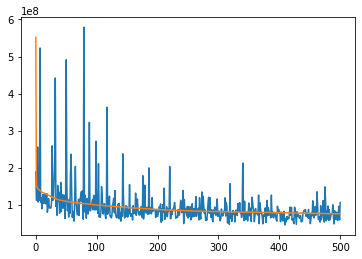

In [13]:
plt.plot(losses)
plt.plot(err_history)
plt.show()

In [14]:
best_model = model_history[np.argmin(err_history)]

In [15]:
xy_test = test
x_data = xy_test.loc[:, 1:7]
x_data = np.array(x_data)
x_data = scaler.transform(x_data)
x_test = torch.FloatTensor(x_data).to(device)

with torch.no_grad():
    model.eval()  # 주의사항 (dropout=False)
    
    predict = best_model(x_test)

In [17]:
test

,1,2,3,5,6,7,9
0,265,107,59.82,2,1994,148,21000
1,24,71,33.48,-1,1991,32,20000
2,610,156,48.08,2,1995,35,15000
3,92,1,110.34,3,1994,260,32700
4,190,54,74.99,2,2008,47,24500
...,...,...,...,...,...,...,...
88184,1464,72,37.88,3,2002,35,23000
88185,129,27,38.22,3,2020,282,51500
88186,181,14,57.64,2,2020,286,48700
88187,686,25,62.97,2,2002,26,26700


In [16]:
test = test.reset_index()
test = test.drop(['index'],axis=1)
test = test.drop(['level_0'],axis=1)

KeyError: "['level_0'] not found in axis"

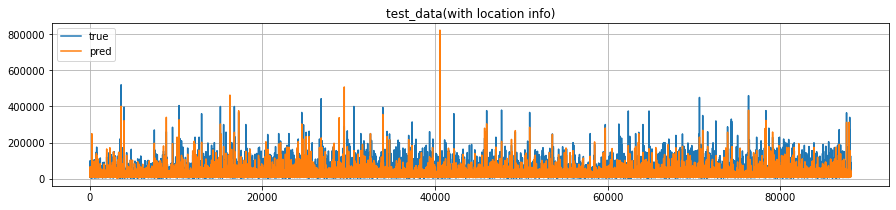

In [22]:
plt.figure(figsize=[15,3])
plt.title('test_data(with location info)')
plt.plot(test[9],label='true')
plt.plot(pd.DataFrame(predict).astype("float"),label='pred')
plt.legend(loc='upper left')
plt.grid()
#plt.show()
plt.savefig('./label_encoding.png')